In [ ]:
!pip install -q tensorflow tensorflow-addons tensorflow-hub tensorflow-datasets
!pip install -q gdown matplotlib seaborn 
!pip install keras-facenet



ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow-addons
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for cv2



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
# import tensorflow_hub as hub
from keras_facenet import FaceNet # type: ignore
import pandas as pd
import numpy as np
import os
from pathlib import Path
import zipfile
import gdown
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive, files
import warnings
warnings.filterwarnings('ignore')

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/

In [2]:
# drive.mount('/content/drive')
DATASET_PATH = "C:/Users/DELL/Downloads/datasets/FairFace"

In [3]:

if os.path.exists(DATASET_PATH):
    print("Path exists.")
else:
    print("Path does not exist.")

# Verify dataset structure
expected_files = [
    "train_labels.csv",
    "val_labels.csv",
    "train/",
    "val/"
]

print(f"Loading dataset from: {DATASET_PATH}")

# Check if all required files/folders exist
missing_files = []
for item in expected_files:
    if not os.path.exists(os.path.join(DATASET_PATH, item)):
        missing_files.append(item)

if missing_files:
    raise FileNotFoundError(
        f"Dataset incomplete. Missing: {missing_files}\n"
        f"Expected structure:\n"
        f"{DATASET_PATH}/\n"
        f"├── train_labels.csv\n"
        f"├── val_labels.csv\n"
        f"├── train/ [contains images]\n"
        f"└── val/   [contains images]"
    )


# Set paths for data loading
TRAIN_CSV_PATH = os.path.join(DATASET_PATH, "train_labels.csv")
VAL_CSV_PATH = os.path.join(DATASET_PATH, "val_labels.csv")
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train")
VAL_IMG_DIR = os.path.join(DATASET_PATH, "val")

print("\nDataset structure verified:")
print(f"Training CSV:   {TRAIN_CSV_PATH}")
print(f"Validation CSV: {VAL_CSV_PATH}")
print(f"Training images: {TRAIN_IMG_DIR} ({len(os.listdir(TRAIN_IMG_DIR))} files)")
print(f"Validation images: {VAL_IMG_DIR} ({len(os.listdir(VAL_IMG_DIR))} files)")

Path exists.
Loading dataset from: C:/Users/DELL/Downloads/datasets/FairFace

Dataset structure verified:
Training CSV:   C:/Users/DELL/Downloads/datasets/FairFace\train_labels.csv
Validation CSV: C:/Users/DELL/Downloads/datasets/FairFace\val_labels.csv
Training images: C:/Users/DELL/Downloads/datasets/FairFace\train (86744 files)
Validation images: C:/Users/DELL/Downloads/datasets/FairFace\val (10954 files)


In [4]:
class FairFaceDataProcessor:
    def __init__(self, csv_path, img_dir, img_size=160, sample_size=None, is_validation=False):
        self.img_size = img_size
        self.img_dir = img_dir
        self.is_validation = is_validation

        # Load CSV data
        self.df = pd.read_csv(csv_path)

        # Filter dataset to keep only valid age groups
        valid_age_groups = [
            '0-2', '3-9', '10-19', '20-29', '30-39',
            '40-49', '50-59', '60-69', 'more than 70'
        ]
        original_len = len(self.df)
        self.df = self.df[self.df['age'].isin(valid_age_groups)].reset_index(drop=True)
        print(f"Removed {original_len - len(self.df)} rows with invalid age groups")

        # Sample data if specified
        if sample_size and sample_size < len(self.df):
            self.df = self.df.sample(n=sample_size, random_state=42).reset_index(drop=True)
            print(f"Sampled {'validation' if is_validation else 'training'}: {len(self.df)} samples")

        # Initialize label encoders only once (use training data to fit)
        if not hasattr(self, 'age_encoder'):
            self.age_encoder = LabelEncoder()
            self.gender_encoder = LabelEncoder()
            self.race_encoder = LabelEncoder()

            # Fit encoders on this dataset
            self.age_encoder.fit(self.df['age'])
            self.gender_encoder.fit(self.df['gender'])
            self.race_encoder.fit(self.df['race'])

        # Encode labels
        self.df['age_encoded'] = self.age_encoder.transform(self.df['age'])
        # self.df['gender_encoded'] = self.gender_encoder.transform(self.df['gender'])
        self.df['gender_encoded'] = (self.df['gender'] == 'Male').astype(int)
        self.df['race_encoded'] = self.race_encoder.transform(self.df['race'])

        self.num_classes = {
            'age': len(self.age_encoder.classes_),
            'gender': len(self.gender_encoder.classes_),
            'race': len(self.race_encoder.classes_)
        }

        print(f"Classes - Age: {self.num_classes['age']}, Gender: {self.num_classes['gender']}, Race: {self.num_classes['race']}")
        if not is_validation:
            print(f"Age groups: {list(self.age_encoder.classes_)}")
            print(f"Gender groups: {list(self.gender_encoder.classes_)}")
            print(f"Race groups: {list(self.race_encoder.classes_)}")

    def filter_missing_files(self):
        """Filter out rows where image files don't exist"""
        print(f"Original dataset size: {len(self.df)}")

        # Check which files exist
        existing_files = []
        for idx, row in self.df.iterrows():
            img_path = os.path.join(self.img_dir, row['file'])
            if os.path.exists(img_path):
                existing_files.append(idx)

        # Filter dataframe to keep only existing files
        self.df = self.df.loc[existing_files].reset_index(drop=True)

        print(f"Filtered dataset size: {len(self.df)}")

        return self

    def load_and_preprocess_image(self, image_path, augment=False):
        """Load and preprocess single image"""
        try:
            # Check if file exists
            if not tf.io.gfile.exists(image_path):
                print(f"Warning: File not found: {image_path}")
                return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [self.img_size, self.img_size])
            image = tf.cast(image, tf.float32) / 255.0

            if augment:
                # Data augmentation
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.image.random_contrast(image, 0.9, 1.1)
                image = tf.image.random_saturation(image, 0.9, 1.1)
                image = tf.image.random_hue(image, 0.05)

            # Normalize using ImageNet statistics (for FaceNet compatibility)
            image = tf.image.per_image_standardization(image)
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return black image if file not found
            return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

    def create_dataset(self, batch_size=32, augment=False, shuffle=True):
        """Create TensorFlow dataset"""
        def generator():
            indices = np.arange(len(self.df))
            if shuffle:
                np.random.shuffle(indices)

            for idx in indices:
                row = self.df.iloc[idx]

                img_path = os.path.join(self.img_dir, row['file'])

                image = self.load_and_preprocess_image(img_path, augment)

                yield (
                    image,
                    {
                        'age_output': tf.cast(row['age_encoded'], dtype=tf.int32),
                        'gender_output': tf.cast(row['gender_encoded'], dtype=tf.int32),
                        'race_output': tf.cast(row['race_encoded'], dtype=tf.int32)
                    }
                )

        # Create dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.img_size, self.img_size, 3), dtype=tf.float32),
                {
                    'age_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'gender_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'race_output': tf.TensorSpec(shape=(), dtype=tf.int32)
                }
            )
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [5]:
class FaceNetMultiTask(tf.keras.Model):
    def __init__(self, num_age_classes, num_gender_classes, num_race_classes,
                 freeze_backbone=False):
        super(FaceNetMultiTask, self).__init__()

        self.backbone = FaceNet().model

        # Freeze backbone
        if freeze_backbone:
            self.backbone.trainable = False

        # # Classification heads
        # self.age_classifier = tf.keras.Sequential([
        #     layers.Dense(512, activation='relu'),
        #     layers.Dropout(0.7),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(num_age_classes, activation='softmax', name='age_output')
        # ], name='age_head')

        # self.gender_classifier = tf.keras.Sequential([
        #     layers.Dense(512, activation='relu'),
        #     layers.Dropout(0.7),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(1, activation='sigmoid', name='gender_output')
        # ], name='gender_head')

        # self.race_classifier = tf.keras.Sequential([
        #     layers.Dense(512, activation='relu'),
        #     layers.Dropout(0.7),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(num_race_classes, activation='softmax', name='race_output')
        # ], name='race_head')

        # Shared dense layer
        self.shared_dense = layers.Dense(512, activation='relu', name='shared_dense')
        self.shared_dropout = layers.Dropout(0.7, name='shared_dropout')

        # Task-specific classification heads
        # age branch
        self.age_classifier = tf.keras.Sequential([
            layers.Dense(128, activation='relu', name='age_dense'),
            layers.Dense(num_age_classes, activation='softmax', name='age_output')
        ], name='age_head')

        # gender branch
        self.gender_classifier = tf.keras.Sequential([
            layers.Dense(1, activation='sigmoid', name='gender_output')
        ], name='gender_head')

        # race branch
        self.race_classifier = tf.keras.Sequential([
            layers.Dense(num_race_classes, activation='softmax', name='race_output')
        ], name='race_head')


    def call(self, inputs, training=None):
        # Get FaceNet embeddings
        embeddings = self.backbone(inputs, training=training)

        # Shared processing
        shared_features = self.shared_dense(embeddings, training=training)
        shared_features = self.shared_dropout(shared_features, training=training)

        # Task-specific predictions
        age_pred = self.age_classifier(shared_features, training=training)
        gender_pred = self.gender_classifier(shared_features, training=training)
        race_pred = self.race_classifier(shared_features, training=training)

        # # Multi-task predictions
        # age_pred = self.age_classifier(embeddings, training=training)
        # gender_pred = self.gender_classifier(embeddings, training=training)
        # race_pred = self.race_classifier(embeddings, training=training)

        return {
            'age_output': age_pred,
            'gender_output': gender_pred,
            'race_output': race_pred
        }

def create_and_compile_model(num_age_classes, num_gender_classes, num_race_classes, freeze_backbone=False):
    """Create and compile the multi-task model """

    model = FaceNetMultiTask(
        num_age_classes=num_age_classes,
        num_gender_classes=num_gender_classes,
        num_race_classes=num_race_classes,
        freeze_backbone=freeze_backbone
    )

    # Build the model
    model.build((None, 160, 160, 3))

    # Optimizer with learning rate schedule
    initial_lr = 0.001

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        loss={
            'age_output': losses.SparseCategoricalCrossentropy(),
            'gender_output': tf.keras.losses.BinaryCrossentropy(),
            'race_output': losses.SparseCategoricalCrossentropy()
        },
        loss_weights={
            'age_output': 1.0,
            'gender_output': 1.0,
            'race_output': 1.0
        },
        metrics={
            'age_output': ['sparse_categorical_accuracy'],
            'gender_output': ['binary_accuracy'],
            'race_output': ['sparse_categorical_accuracy']
        }
    )

    print(f"\n Model compiled successfully!")
    print(f"   - Backbone frozen: {freeze_backbone}")
    print(f"   - Learning rate: {initial_lr}")

    return model

In [6]:
BATCH_SIZE = 32
IMG_SIZE = 160
EPOCHS = 20
SAMPLE_SIZE = 86000

print("Creating training data processor...")
train_processor = FairFaceDataProcessor(
    TRAIN_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE,
    is_validation=False
).filter_missing_files()

print("\nCreating validation data processor...")
val_processor = FairFaceDataProcessor(
    VAL_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE//5 if SAMPLE_SIZE else None,
    is_validation=True
).filter_missing_files()

# Copy encoders from training to validation processor
val_processor.age_encoder = train_processor.age_encoder
val_processor.gender_encoder = train_processor.gender_encoder
val_processor.race_encoder = train_processor.race_encoder

# Re-encode validation labels with training encoders
val_processor.df['age_encoded'] = val_processor.age_encoder.transform(val_processor.df['age'])
val_processor.df['gender_encoded'] = val_processor.gender_encoder.transform(val_processor.df['gender'])
val_processor.df['race_encoded'] = val_processor.race_encoder.transform(val_processor.df['race'])

print("\nCreating datasets...")
train_dataset = train_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True
)

val_dataset = val_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)


Creating training data processor...
Removed 0 rows with invalid age groups
Sampled training: 86000 samples
Classes - Age: 9, Gender: 2, Race: 7
Age groups: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Gender groups: ['Female', 'Male']
Race groups: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Original dataset size: 86000
Filtered dataset size: 86000

Creating validation data processor...
Removed 0 rows with invalid age groups
Classes - Age: 9, Gender: 2, Race: 7
Original dataset size: 10954
Filtered dataset size: 10954

Creating datasets...


In [11]:
print("Building model...")
model = create_and_compile_model(
    num_age_classes=train_processor.num_classes['age'],
    num_gender_classes=train_processor.num_classes['gender'],
    num_race_classes=train_processor.num_classes['race'],
    freeze_backbone=True 
)

print(model.summary())

Building model...

 Model compiled successfully!
   - Backbone frozen: True
   - Learning rate: 0.001


Model: "face_net_multi_task_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v1             │ (None, 512)            │    23,497,424 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_head (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_head (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ race_head (Sequential)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,497,424 (89.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,497,424 (89.64 MB)

None


In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_fairface_facenet_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('training_log.csv')
]



In [13]:
def verify_dataset_structure():
    print("=== Dataset Structure Verification ===")

    # Check CSV files
    train_csv = pd.read_csv(TRAIN_CSV_PATH)
    val_csv = pd.read_csv(VAL_CSV_PATH)

    print(f"Training CSV shape: {train_csv.shape}")
    print(f"Validation CSV shape: {val_csv.shape}")
    print(f"Training CSV columns: {list(train_csv.columns)}")

    # Check image directories
    train_images = os.listdir(TRAIN_IMG_DIR)
    val_images = os.listdir(VAL_IMG_DIR) if os.path.exists(VAL_IMG_DIR) else []

    print(f"Training images found: {len(train_images)}")
    print(f"Validation images found: {len(val_images)}")

    # Check if CSV files match image files
    print("\n=== File Matching Check ===")

    # Sample a few files from CSV and check if they exist
    sample_files = train_csv['file'].head(10).tolist()
    missing_files = []

    for file_name in sample_files:
        # full_path = os.path.join(TRAIN_IMG_DIR, file_name)
        full_path = os.path.join(DATASET_PATH, file_name)
        if not os.path.exists(full_path):
            missing_files.append(full_path)
        else:
            print(f"✓ Found: {full_path}")

    if missing_files:
        print(f"✗ Missing files: {missing_files}")
    else:
        print("✓ All sampled files found!")

    # Check first few rows of CSV
    print(f"\nFirst few rows of training CSV:")
    print(train_csv.head())

    return len(missing_files) == 0

# Run verification
dataset_ok = verify_dataset_structure()

if dataset_ok:
    print("\n✓ Dataset structure looks good! Proceeding with training...")
else:
    print("\n✗ Dataset structure issues found. Please check file paths.")

=== Dataset Structure Verification ===
Training CSV shape: (86744, 5)
Validation CSV shape: (10954, 5)
Training CSV columns: ['file', 'age', 'gender', 'race', 'service_test']
Training images found: 86744
Validation images found: 10954

=== File Matching Check ===
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/1.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/2.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/3.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/4.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/5.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/6.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/7.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/8.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/9.jpg
✓ Found: C:/Users/DELL/Downloads/datasets/FairFace\train/10.jpg
✓ All sampled files found!

First few rows of training CSV:
          file    age  gender        race  se

In [14]:
print("Starting training...")
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting training...
Epoch 1/50
   2688/Unknown 3572s 1s/step - age_output_loss: 1.3817 - age_output_sparse_categorical_accuracy: 0.4397 - gender_output_binary_accuracy: 0.8408 - gender_output_loss: 0.3773 - loss: 2.9919 - race_output_loss: 1.2329 - race_output_sparse_categorical_accuracy: 0.5470
Epoch 1: val_loss improved from None to 2.48321, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3922s 1s/step - age_output_loss: 1.2897 - age_output_sparse_categorical_accuracy: 0.4657 - gender_output_binary_accuracy: 0.8559 - gender_output_loss: 0.3333 - loss: 2.7779 - race_output_loss: 1.1537 - race_output_sparse_categorical_accuracy: 0.5668 - val_age_output_loss: 1.1671 - val_age_output_sparse_categorical_accuracy: 0.5135 - val_gender_output_binary_accuracy: 0.8726 - val_gender_output_loss: 0.2856 - val_loss: 2.4832 - val_race_output_loss: 1.0224 - val_race_output_sparse_categorical_accuracy: 0.6092 - learning_rate: 0.0010
Epoch 2/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - age_output_loss: 1.2264 - age_output_sparse_categorical_accuracy: 0.4894 - gender_output_binary_accuracy: 0.8677 - gender_output_loss: 0.3007 - loss: 2.6388 - race_output_loss: 1.1117 - race_output_sparse_categorical_accuracy: 0.5801
Epoch 2: val_loss improved from 2.48321 to 2.43982, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3068s 1s/step - age_output_loss: 1.2252 - age_output_sparse_categorical_accuracy: 0.4915 - gender_output_binary_accuracy: 0.8680 - gender_output_loss: 0.2988 - loss: 2.6329 - race_output_loss: 1.1079 - race_output_sparse_categorical_accuracy: 0.5813 - val_age_output_loss: 1.1446 - val_age_output_sparse_categorical_accuracy: 0.5259 - val_gender_output_binary_accuracy: 0.8800 - val_gender_output_loss: 0.2741 - val_loss: 2.4398 - val_race_output_loss: 1.0132 - val_race_output_sparse_categorical_accuracy: 0.6132 - learning_rate: 0.0010
Epoch 3/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.2127 - age_output_sparse_categorical_accuracy: 0.4948 - gender_output_binary_accuracy: 0.8699 - gender_output_loss: 0.2939 - loss: 2.6117 - race_output_loss: 1.1051 - race_output_sparse_categorical_accuracy: 0.5826
Epoch 3: val_loss improved from 2.43982 to 2.43060, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3200s 1s/step - age_output_loss: 1.2126 - age_output_sparse_categorical_accuracy: 0.4932 - gender_output_binary_accuracy: 0.8702 - gender_output_loss: 0.2941 - loss: 2.6095 - race_output_loss: 1.1018 - race_output_sparse_categorical_accuracy: 0.5832 - val_age_output_loss: 1.1457 - val_age_output_sparse_categorical_accuracy: 0.5266 - val_gender_output_binary_accuracy: 0.8796 - val_gender_output_loss: 0.2693 - val_loss: 2.4306 - val_race_output_loss: 1.0079 - val_race_output_sparse_categorical_accuracy: 0.6120 - learning_rate: 0.0010
Epoch 4/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - age_output_loss: 1.2061 - age_output_sparse_categorical_accuracy: 0.4973 - gender_output_binary_accuracy: 0.8721 - gender_output_loss: 0.2909 - loss: 2.5895 - race_output_loss: 1.0925 - race_output_sparse_categorical_accuracy: 0.5857
Epoch 4: val_loss improved from 2.43060 to 2.41353, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2584s 959ms/step - age_output_loss: 1.2067 - age_output_sparse_categorical_accuracy: 0.4973 - gender_output_binary_accuracy: 0.8714 - gender_output_loss: 0.2926 - loss: 2.5963 - race_output_loss: 1.0960 - race_output_sparse_categorical_accuracy: 0.5843 - val_age_output_loss: 1.1331 - val_age_output_sparse_categorical_accuracy: 0.5278 - val_gender_output_binary_accuracy: 0.8796 - val_gender_output_loss: 0.2679 - val_loss: 2.4135 - val_race_output_loss: 1.0048 - val_race_output_sparse_categorical_accuracy: 0.6169 - learning_rate: 0.0010
Epoch 5/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - age_output_loss: 1.2002 - age_output_sparse_categorical_accuracy: 0.4999 - gender_output_binary_accuracy: 0.8712 - gender_output_loss: 0.2886 - loss: 2.5839 - race_output_loss: 1.0951 - race_output_sparse_categorical_accuracy: 0.5850
Epoch 5: val_loss did not improve from 2.41353
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2874s 1s/step - age_output_loss: 1.2023 - age_output_spars

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2845s 1s/step - age_output_loss: 1.1959 - age_output_sparse_categorical_accuracy: 0.5013 - gender_output_binary_accuracy: 0.8737 - gender_output_loss: 0.2866 - loss: 2.5757 - race_output_loss: 1.0921 - race_output_sparse_categorical_accuracy: 0.5871 - val_age_output_loss: 1.1384 - val_age_output_sparse_categorical_accuracy: 0.5272 - val_gender_output_binary_accuracy: 0.8814 - val_gender_output_loss: 0.2649 - val_loss: 2.4095 - val_race_output_loss: 0.9984 - val_race_output_sparse_categorical_accuracy: 0.6182 - learning_rate: 0.0010
Epoch 8/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - age_output_loss: 1.1972 - age_output_sparse_categorical_accuracy: 0.4978 - gender_output_binary_accuracy: 0.8730 - gender_output_loss: 0.2869 - loss: 2.5743 - race_output_loss: 1.0903 - race_output_sparse_categorical_accuracy: 0.5894
Epoch 8: val_loss improved from 2.40950 to 2.40650, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2870s 1s/step - age_output_loss: 1.1959 - age_output_sparse_categorical_accuracy: 0.4992 - gender_output_binary_accuracy: 0.8739 - gender_output_loss: 0.2849 - loss: 2.5712 - race_output_loss: 1.0894 - race_output_sparse_categorical_accuracy: 0.5882 - val_age_output_loss: 1.1341 - val_age_output_sparse_categorical_accuracy: 0.5292 - val_gender_output_binary_accuracy: 0.8835 - val_gender_output_loss: 0.2641 - val_loss: 2.4065 - val_race_output_loss: 1.0007 - val_race_output_sparse_categorical_accuracy: 0.6168 - learning_rate: 0.0010
Epoch 9/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - age_output_loss: 1.1869 - age_output_sparse_categorical_accuracy: 0.5039 - gender_output_binary_accuracy: 0.8741 - gender_output_loss: 0.2851 - loss: 2.5604 - race_output_loss: 1.0884 - race_output_sparse_categorical_accuracy: 0.5886
Epoch 9: val_loss improved from 2.40650 to 2.40203, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2698s 1s/step - age_output_loss: 1.1897 - age_output_sparse_categorical_accuracy: 0.5026 - gender_output_binary_accuracy: 0.8739 - gender_output_loss: 0.2848 - loss: 2.5642 - race_output_loss: 1.0887 - race_output_sparse_categorical_accuracy: 0.5881 - val_age_output_loss: 1.1315 - val_age_output_sparse_categorical_accuracy: 0.5237 - val_gender_output_binary_accuracy: 0.8829 - val_gender_output_loss: 0.2653 - val_loss: 2.4020 - val_race_output_loss: 0.9977 - val_race_output_sparse_categorical_accuracy: 0.6185 - learning_rate: 0.0010
Epoch 10/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1843 - age_output_sparse_categorical_accuracy: 0.5055 - gender_output_binary_accuracy: 0.8749 - gender_output_loss: 0.2872 - loss: 2.5576 - race_output_loss: 1.0861 - race_output_sparse_categorical_accuracy: 0.5881
Epoch 10: val_loss did not improve from 2.40203
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3105s 1s/step - age_output_loss: 1.1882 - age_output_sparse_ca

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3075s 1s/step - age_output_loss: 1.1884 - age_output_sparse_categorical_accuracy: 0.5042 - gender_output_binary_accuracy: 0.8754 - gender_output_loss: 0.2837 - loss: 2.5619 - race_output_loss: 1.0889 - race_output_sparse_categorical_accuracy: 0.5886 - val_age_output_loss: 1.1298 - val_age_output_sparse_categorical_accuracy: 0.5283 - val_gender_output_binary_accuracy: 0.8830 - val_gender_output_loss: 0.2636 - val_loss: 2.3990 - val_race_output_loss: 0.9981 - val_race_output_sparse_categorical_accuracy: 0.6190 - learning_rate: 0.0010
Epoch 12/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1852 - age_output_sparse_categorical_accuracy: 0.5080 - gender_output_binary_accuracy: 0.8750 - gender_output_loss: 0.2819 - loss: 2.5533 - race_output_loss: 1.0862 - race_output_sparse_categorical_accuracy: 0.5889
Epoch 12: val_loss did not improve from 2.39900
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3238s 1s/step - age_output_loss: 1.1876 - age_output_sparse_ca

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3244s 1s/step - age_output_loss: 1.1839 - age_output_sparse_categorical_accuracy: 0.5055 - gender_output_binary_accuracy: 0.8761 - gender_output_loss: 0.2824 - loss: 2.5524 - race_output_loss: 1.0851 - race_output_sparse_categorical_accuracy: 0.5908 - val_age_output_loss: 1.1306 - val_age_output_sparse_categorical_accuracy: 0.5293 - val_gender_output_binary_accuracy: 0.8818 - val_gender_output_loss: 0.2629 - val_loss: 2.3972 - val_race_output_loss: 0.9963 - val_race_output_sparse_categorical_accuracy: 0.6179 - learning_rate: 0.0010
Epoch 14/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1809 - age_output_sparse_categorical_accuracy: 0.5060 - gender_output_binary_accuracy: 0.8741 - gender_output_loss: 0.2870 - loss: 2.5551 - race_output_loss: 1.0873 - race_output_sparse_categorical_accuracy: 0.5877
Epoch 14: val_loss did not improve from 2.39722
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 4191s 2s/step - age_output_loss: 1.1843 - age_output_sparse_ca

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2825s 1s/step - age_output_loss: 1.1816 - age_output_sparse_categorical_accuracy: 0.5064 - gender_output_binary_accuracy: 0.8754 - gender_output_loss: 0.2812 - loss: 2.5485 - race_output_loss: 1.0848 - race_output_sparse_categorical_accuracy: 0.5875 - val_age_output_loss: 1.1252 - val_age_output_sparse_categorical_accuracy: 0.5271 - val_gender_output_binary_accuracy: 0.8829 - val_gender_output_loss: 0.2628 - val_loss: 2.3933 - val_race_output_loss: 0.9976 - val_race_output_sparse_categorical_accuracy: 0.6180 - learning_rate: 0.0010
Epoch 16/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - age_output_loss: 1.1816 - age_output_sparse_categorical_accuracy: 0.5080 - gender_output_binary_accuracy: 0.8758 - gender_output_loss: 0.2803 - loss: 2.5447 - race_output_loss: 1.0829 - race_output_sparse_categorical_accuracy: 0.5900
Epoch 16: val_loss improved from 2.39333 to 2.39181, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 7590s 3s/step - age_output_loss: 1.1813 - age_output_sparse_categorical_accuracy: 0.5052 - gender_output_binary_accuracy: 0.8762 - gender_output_loss: 0.2813 - loss: 2.5474 - race_output_loss: 1.0840 - race_output_sparse_categorical_accuracy: 0.5893 - val_age_output_loss: 1.1291 - val_age_output_sparse_categorical_accuracy: 0.5267 - val_gender_output_binary_accuracy: 0.8832 - val_gender_output_loss: 0.2616 - val_loss: 2.3918 - val_race_output_loss: 0.9935 - val_race_output_sparse_categorical_accuracy: 0.6190 - learning_rate: 0.0010
Epoch 17/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1754 - age_output_sparse_categorical_accuracy: 0.5079 - gender_output_binary_accuracy: 0.8741 - gender_output_loss: 0.2833 - loss: 2.5406 - race_output_loss: 1.0819 - race_output_sparse_categorical_accuracy: 0.5891
Epoch 17: val_loss improved from 2.39181 to 2.39060, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 10078s 4s/step - age_output_loss: 1.1794 - age_output_sparse_categorical_accuracy: 0.5071 - gender_output_binary_accuracy: 0.8747 - gender_output_loss: 0.2824 - loss: 2.5471 - race_output_loss: 1.0845 - race_output_sparse_categorical_accuracy: 0.5891 - val_age_output_loss: 1.1260 - val_age_output_sparse_categorical_accuracy: 0.5314 - val_gender_output_binary_accuracy: 0.8824 - val_gender_output_loss: 0.2635 - val_loss: 2.3906 - val_race_output_loss: 0.9933 - val_race_output_sparse_categorical_accuracy: 0.6183 - learning_rate: 0.0010
Epoch 18/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1797 - age_output_sparse_categorical_accuracy: 0.5060 - gender_output_binary_accuracy: 0.8760 - gender_output_loss: 0.2825 - loss: 2.5418 - race_output_loss: 1.0796 - race_output_sparse_categorical_accuracy: 0.5922
Epoch 18: val_loss did not improve from 2.39060
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3570s 1s/step - age_output_loss: 1.1794 - age_output_sparse_c

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2717s 1s/step - age_output_loss: 1.1781 - age_output_sparse_categorical_accuracy: 0.5067 - gender_output_binary_accuracy: 0.8768 - gender_output_loss: 0.2801 - loss: 2.5432 - race_output_loss: 1.0840 - race_output_sparse_categorical_accuracy: 0.5903 - val_age_output_loss: 1.1253 - val_age_output_sparse_categorical_accuracy: 0.5331 - val_gender_output_binary_accuracy: 0.8838 - val_gender_output_loss: 0.2623 - val_loss: 2.3897 - val_race_output_loss: 0.9946 - val_race_output_sparse_categorical_accuracy: 0.6168 - learning_rate: 0.0010
Epoch 21/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1749 - age_output_sparse_categorical_accuracy: 0.5071 - gender_output_binary_accuracy: 0.8774 - gender_output_loss: 0.2803 - loss: 2.5355 - race_output_loss: 1.0804 - race_output_sparse_categorical_accuracy: 0.5892
Epoch 21: val_loss did not improve from 2.38969
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5445s 2s/step - age_output_loss: 1.1768 - age_output_sparse_ca

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2786s 1s/step - age_output_loss: 1.1784 - age_output_sparse_categorical_accuracy: 0.5063 - gender_output_binary_accuracy: 0.8747 - gender_output_loss: 0.2822 - loss: 2.5426 - race_output_loss: 1.0811 - race_output_sparse_categorical_accuracy: 0.5905 - val_age_output_loss: 1.1293 - val_age_output_sparse_categorical_accuracy: 0.5274 - val_gender_output_binary_accuracy: 0.8823 - val_gender_output_loss: 0.2602 - val_loss: 2.3880 - val_race_output_loss: 0.9910 - val_race_output_sparse_categorical_accuracy: 0.6210 - learning_rate: 0.0010
Epoch 23/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1773 - age_output_sparse_categorical_accuracy: 0.5067 - gender_output_binary_accuracy: 0.8740 - gender_output_loss: 0.2855 - loss: 2.5421 - race_output_loss: 1.0793 - race_output_sparse_categorical_accuracy: 0.5910
Epoch 23: val_loss did not improve from 2.38802
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3666s 1s/step - age_output_loss: 1.1775 - age_output_sparse_ca

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3173s 1s/step - age_output_loss: 1.1769 - age_output_sparse_categorical_accuracy: 0.5091 - gender_output_binary_accuracy: 0.8770 - gender_output_loss: 0.2807 - loss: 2.5403 - race_output_loss: 1.0819 - race_output_sparse_categorical_accuracy: 0.5896 - val_age_output_loss: 1.1229 - val_age_output_sparse_categorical_accuracy: 0.5327 - val_gender_output_binary_accuracy: 0.8841 - val_gender_output_loss: 0.2615 - val_loss: 2.3840 - val_race_output_loss: 0.9922 - val_race_output_sparse_categorical_accuracy: 0.6226 - learning_rate: 0.0010
Epoch 26/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1786 - age_output_sparse_categorical_accuracy: 0.5096 - gender_output_binary_accuracy: 0.8760 - gender_output_loss: 0.2808 - loss: 2.5432 - race_output_loss: 1.0838 - race_output_sparse_categorical_accuracy: 0.5894
Epoch 26: val_loss did not improve from 2.38404
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3158s 1s/step - age_output_loss: 1.1744 - age_output_sparse_ca

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5204s 2s/step - age_output_loss: 1.1648 - age_output_sparse_categorical_accuracy: 0.5127 - gender_output_binary_accuracy: 0.8775 - gender_output_loss: 0.2775 - loss: 2.5122 - race_output_loss: 1.0689 - race_output_sparse_categorical_accuracy: 0.5951 - val_age_output_loss: 1.1182 - val_age_output_sparse_categorical_accuracy: 0.5316 - val_gender_output_binary_accuracy: 0.8835 - val_gender_output_loss: 0.2610 - val_loss: 2.3781 - val_race_output_loss: 0.9915 - val_race_output_sparse_categorical_accuracy: 0.6213 - learning_rate: 5.0000e-04
Epoch 32/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1576 - age_output_sparse_categorical_accuracy: 0.5148 - gender_output_binary_accuracy: 0.8807 - gender_output_loss: 0.2724 - loss: 2.4911 - race_output_loss: 1.0610 - race_output_sparse_categorical_accuracy: 0.5972
Epoch 32: val_loss improved from 2.37813 to 2.37486, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5229s 2s/step - age_output_loss: 1.1609 - age_output_sparse_categorical_accuracy: 0.5142 - gender_output_binary_accuracy: 0.8781 - gender_output_loss: 0.2767 - loss: 2.5038 - race_output_loss: 1.0652 - race_output_sparse_categorical_accuracy: 0.5960 - val_age_output_loss: 1.1182 - val_age_output_sparse_categorical_accuracy: 0.5335 - val_gender_output_binary_accuracy: 0.8837 - val_gender_output_loss: 0.2608 - val_loss: 2.3749 - val_race_output_loss: 0.9882 - val_race_output_sparse_categorical_accuracy: 0.6232 - learning_rate: 5.0000e-04
Epoch 33/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1518 - age_output_sparse_categorical_accuracy: 0.5173 - gender_output_binary_accuracy: 0.8779 - gender_output_loss: 0.2756 - loss: 2.4919 - race_output_loss: 1.0646 - race_output_sparse_categorical_accuracy: 0.5979
Epoch 33: val_loss did not improve from 2.37486
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5491s 2s/step - age_output_loss: 1.1579 - age_output_spars

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5858s 2s/step - age_output_loss: 1.1591 - age_output_sparse_categorical_accuracy: 0.5130 - gender_output_binary_accuracy: 0.8789 - gender_output_loss: 0.2752 - loss: 2.4980 - race_output_loss: 1.0628 - race_output_sparse_categorical_accuracy: 0.5975 - val_age_output_loss: 1.1192 - val_age_output_sparse_categorical_accuracy: 0.5299 - val_gender_output_binary_accuracy: 0.8845 - val_gender_output_loss: 0.2600 - val_loss: 2.3745 - val_race_output_loss: 0.9878 - val_race_output_sparse_categorical_accuracy: 0.6209 - learning_rate: 5.0000e-04
Epoch 37/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1531 - age_output_sparse_categorical_accuracy: 0.5187 - gender_output_binary_accuracy: 0.8782 - gender_output_loss: 0.2761 - loss: 2.4860 - race_output_loss: 1.0568 - race_output_sparse_categorical_accuracy: 0.6015
Epoch 37: val_loss did not improve from 2.37447
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5490s 2s/step - age_output_loss: 1.1556 - age_output_spars

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5361s 2s/step - age_output_loss: 1.1548 - age_output_sparse_categorical_accuracy: 0.5179 - gender_output_binary_accuracy: 0.8791 - gender_output_loss: 0.2760 - loss: 2.4958 - race_output_loss: 1.0643 - race_output_sparse_categorical_accuracy: 0.5956 - val_age_output_loss: 1.1159 - val_age_output_sparse_categorical_accuracy: 0.5330 - val_gender_output_binary_accuracy: 0.8854 - val_gender_output_loss: 0.2599 - val_loss: 2.3705 - val_race_output_loss: 0.9872 - val_race_output_sparse_categorical_accuracy: 0.6239 - learning_rate: 5.0000e-04
Epoch 40/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1542 - age_output_sparse_categorical_accuracy: 0.5182 - gender_output_binary_accuracy: 0.8798 - gender_output_loss: 0.2745 - loss: 2.4896 - race_output_loss: 1.0610 - race_output_sparse_categorical_accuracy: 0.6016
Epoch 40: val_loss improved from 2.37052 to 2.36841, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5422s 2s/step - age_output_loss: 1.1545 - age_output_sparse_categorical_accuracy: 0.5186 - gender_output_binary_accuracy: 0.8798 - gender_output_loss: 0.2733 - loss: 2.4921 - race_output_loss: 1.0634 - race_output_sparse_categorical_accuracy: 0.5990 - val_age_output_loss: 1.1152 - val_age_output_sparse_categorical_accuracy: 0.5337 - val_gender_output_binary_accuracy: 0.8842 - val_gender_output_loss: 0.2592 - val_loss: 2.3684 - val_race_output_loss: 0.9865 - val_race_output_sparse_categorical_accuracy: 0.6235 - learning_rate: 5.0000e-04
Epoch 41/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1500 - age_output_sparse_categorical_accuracy: 0.5187 - gender_output_binary_accuracy: 0.8776 - gender_output_loss: 0.2771 - loss: 2.4867 - race_output_loss: 1.0596 - race_output_sparse_categorical_accuracy: 0.5991
Epoch 41: val_loss did not improve from 2.36841
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5441s 2s/step - age_output_loss: 1.1544 - age_output_spars

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5938s 2s/step - age_output_loss: 1.1500 - age_output_sparse_categorical_accuracy: 0.5181 - gender_output_binary_accuracy: 0.8798 - gender_output_loss: 0.2730 - loss: 2.4845 - race_output_loss: 1.0605 - race_output_sparse_categorical_accuracy: 0.5999 - val_age_output_loss: 1.1140 - val_age_output_sparse_categorical_accuracy: 0.5369 - val_gender_output_binary_accuracy: 0.8853 - val_gender_output_loss: 0.2600 - val_loss: 2.3675 - val_race_output_loss: 0.9861 - val_race_output_sparse_categorical_accuracy: 0.6233 - learning_rate: 5.0000e-04
Epoch 45/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 1.1521 - age_output_sparse_categorical_accuracy: 0.5166 - gender_output_binary_accuracy: 0.8812 - gender_output_loss: 0.2753 - loss: 2.4855 - race_output_loss: 1.0581 - race_output_sparse_categorical_accuracy: 0.6006
Epoch 45: val_loss did not improve from 2.36755
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 5772s 2s/step - age_output_loss: 1.1534 - age_output_spars

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3631s 1s/step - age_output_loss: 1.1536 - age_output_sparse_categorical_accuracy: 0.5170 - gender_output_binary_accuracy: 0.8797 - gender_output_loss: 0.2734 - loss: 2.4905 - race_output_loss: 1.0626 - race_output_sparse_categorical_accuracy: 0.5988 - val_age_output_loss: 1.1143 - val_age_output_sparse_categorical_accuracy: 0.5378 - val_gender_output_binary_accuracy: 0.8844 - val_gender_output_loss: 0.2602 - val_loss: 2.3675 - val_race_output_loss: 0.9855 - val_race_output_sparse_categorical_accuracy: 0.6240 - learning_rate: 5.0000e-04
Epoch 49/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1491 - age_output_sparse_categorical_accuracy: 0.5222 - gender_output_binary_accuracy: 0.8788 - gender_output_loss: 0.2752 - loss: 2.4824 - race_output_loss: 1.0581 - race_output_sparse_categorical_accuracy: 0.5999
Epoch 49: val_loss improved from 2.36752 to 2.36715, saving model to best_fairface_facenet_model.h5


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3599s 1s/step - age_output_loss: 1.1514 - age_output_sparse_categorical_accuracy: 0.5192 - gender_output_binary_accuracy: 0.8787 - gender_output_loss: 0.2756 - loss: 2.4871 - race_output_loss: 1.0592 - race_output_sparse_categorical_accuracy: 0.6008 - val_age_output_loss: 1.1147 - val_age_output_sparse_categorical_accuracy: 0.5334 - val_gender_output_binary_accuracy: 0.8853 - val_gender_output_loss: 0.2598 - val_loss: 2.3671 - val_race_output_loss: 0.9852 - val_race_output_sparse_categorical_accuracy: 0.6217 - learning_rate: 5.0000e-04
Epoch 50/50
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_output_loss: 1.1497 - age_output_sparse_categorical_accuracy: 0.5183 - gender_output_binary_accuracy: 0.8781 - gender_output_loss: 0.2769 - loss: 2.4918 - race_output_loss: 1.0652 - race_output_sparse_categorical_accuracy: 0.5954
Epoch 50: val_loss did not improve from 2.36715
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3737s 1s/step - age_output_loss: 1.1526 - age_output_spars

In [15]:
print("Available history keys:", list(history.history.keys()))

Available history keys: ['age_output_loss', 'age_output_sparse_categorical_accuracy', 'gender_output_binary_accuracy', 'gender_output_loss', 'loss', 'race_output_loss', 'race_output_sparse_categorical_accuracy', 'val_age_output_loss', 'val_age_output_sparse_categorical_accuracy', 'val_gender_output_binary_accuracy', 'val_gender_output_loss', 'val_loss', 'val_race_output_loss', 'val_race_output_sparse_categorical_accuracy', 'learning_rate']


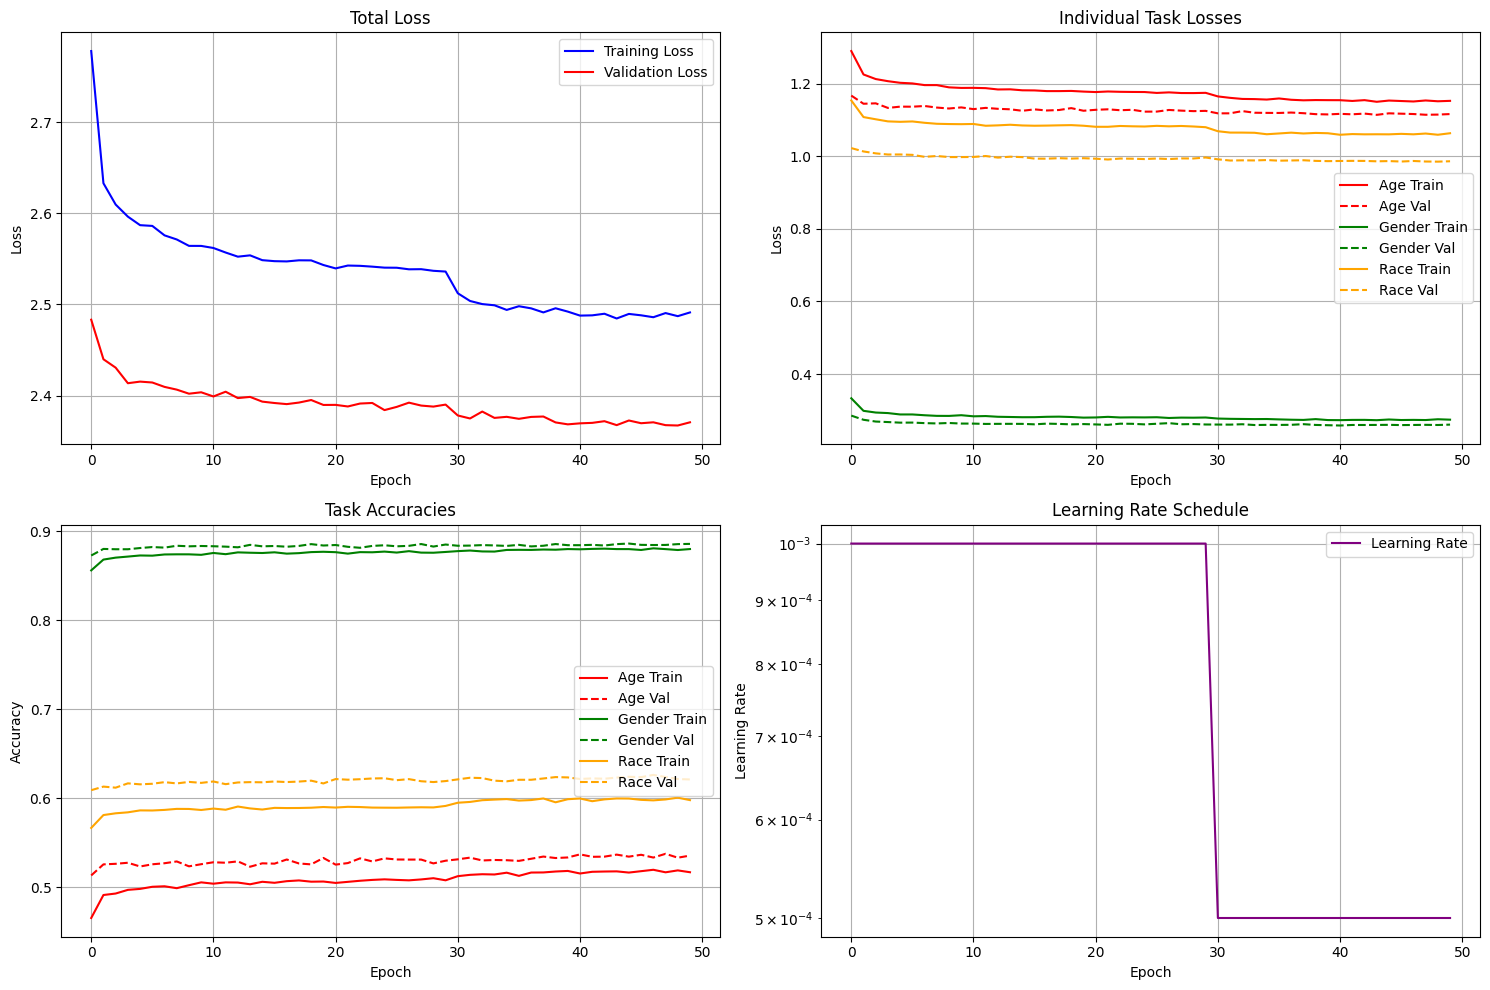

Final Training Metrics:
Total Loss: 2.4912 | Val Loss: 2.3707
Age Loss: 1.1526 | Val: 1.1162
Gender Loss: 0.2744 | Val: 0.2608
Race Loss: 1.0634 | Val: 0.9862
Age Accuracy: 0.5171 | Val: 0.5358
Gender Accuracy: 0.8798 | Val: 0.8856
Race Accuracy: 0.5980 | Val: 0.6212
Final Learning Rate: 5.00e-04


In [16]:
def plot_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total Loss (Training vs Validation)
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Individual Task Losses
    ax2.plot(history.history['age_output_loss'], label='Age Train', color='red', linestyle='-')
    ax2.plot(history.history['val_age_output_loss'], label='Age Val', color='red', linestyle='--')
    ax2.plot(history.history['gender_output_loss'], label='Gender Train', color='green', linestyle='-')
    ax2.plot(history.history['val_gender_output_loss'], label='Gender Val', color='green', linestyle='--')
    ax2.plot(history.history['race_output_loss'], label='Race Train', color='orange', linestyle='-')
    ax2.plot(history.history['val_race_output_loss'], label='Race Val', color='orange', linestyle='--')
    ax2.set_title('Individual Task Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Task Accuracies 
    ax3.plot(history.history['age_output_sparse_categorical_accuracy'], label='Age Train', color='red', linestyle='-')
    ax3.plot(history.history['val_age_output_sparse_categorical_accuracy'], label='Age Val', color='red', linestyle='--')
    ax3.plot(history.history['gender_output_binary_accuracy'], label='Gender Train', color='green', linestyle='-')
    ax3.plot(history.history['val_gender_output_binary_accuracy'], label='Gender Val', color='green', linestyle='--')
    ax3.plot(history.history['race_output_sparse_categorical_accuracy'], label='Race Train', color='orange', linestyle='-')
    ax3.plot(history.history['val_race_output_sparse_categorical_accuracy'], label='Race Val', color='orange', linestyle='--')
    ax3.set_title('Task Accuracies')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Learning Rate
    ax4.plot(history.history['learning_rate'], label='Learning Rate', color='purple')
    ax4.set_title('Learning Rate Schedule')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.legend()
    ax4.grid(True)
    ax4.set_yscale('log') 

    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("Final Training Metrics:")
    print(f"Total Loss: {history.history['loss'][-1]:.4f} | Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Age Loss: {history.history['age_output_loss'][-1]:.4f} | Val: {history.history['val_age_output_loss'][-1]:.4f}")
    print(f"Gender Loss: {history.history['gender_output_loss'][-1]:.4f} | Val: {history.history['val_gender_output_loss'][-1]:.4f}")
    print(f"Race Loss: {history.history['race_output_loss'][-1]:.4f} | Val: {history.history['val_race_output_loss'][-1]:.4f}")
    print(f"Age Accuracy: {history.history['age_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_age_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Gender Accuracy: {history.history['gender_output_binary_accuracy'][-1]:.4f} | Val: {history.history['val_gender_output_binary_accuracy'][-1]:.4f}")
    print(f"Race Accuracy: {history.history['race_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_race_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Final Learning Rate: {history.history['learning_rate'][-1]:.2e}")

plot_history(history)

In [17]:
def predict_sample(model, img_path, train_processor, img_size=(160, 160)):
    """
    Predict demographics for a single image
    """
    # Load and preprocess image - matching training preprocessing
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Apply same normalization as training (ImageNet standardization)
    img = tf.image.per_image_standardization(img)
    img = tf.expand_dims(img, axis=0)  # Add batch dim

    # Predict
    preds = model.predict(img, verbose=0)

    # Extract predictions - model returns a dictionary
    age_pred = np.argmax(preds['age_output'][0])
    gender_pred = np.argmax(preds['gender_output'][0])
    race_pred = np.argmax(preds['race_output'][0])

    # Decode labels using the training processor encoders
    age_label = train_processor.age_encoder.inverse_transform([age_pred])[0]
    gender_label = train_processor.gender_encoder.inverse_transform([gender_pred])[0]
    race_label = train_processor.race_encoder.inverse_transform([race_pred])[0]

    # Display - load original image for display
    display_img = tf.io.read_file(img_path)
    display_img = tf.image.decode_image(display_img, channels=3)
    display_img = tf.image.resize(display_img, img_size)
    display_img = tf.cast(display_img, tf.float32) / 255.0

    plt.figure(figsize=(8, 6))
    plt.imshow(display_img)
    plt.title(f"Predictions:\nAge: {age_label}\nGender: {gender_label}\nRace: {race_label}")
    plt.axis('off')
    plt.show()

    return age_label, gender_label, race_label

In [18]:
def test_predictions(model, train_processor, num_samples=3):
    """Test predictions on random samples from filtered training data"""

    # Get some sample files from the filtered training data
    sample_indices = np.random.choice(len(train_processor.df), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        print(f"\n=== Sample {i+1} ===")
        row = train_processor.df.iloc[idx]
        img_path = os.path.join(train_processor.img_dir, row['file'])

        # True labels
        true_age = row['age']
        true_gender = row['gender']
        true_race = row['race']

        print(f"True labels - Age: {true_age}, Gender: {true_gender}, Race: {true_race}")

        # Predict
        pred_age, pred_gender, pred_race = predict_sample(model, img_path, train_processor)

        # Compare
        print(f"Predicted - Age: {pred_age}, Gender: {pred_gender}, Race: {pred_race}")
        print(f"Correct - Age: {true_age == pred_age}, Gender: {true_gender == pred_gender}, Race: {true_race == pred_race}")


=== Sample 1 ===
True labels - Age: 20-29, Gender: Male, Race: Indian


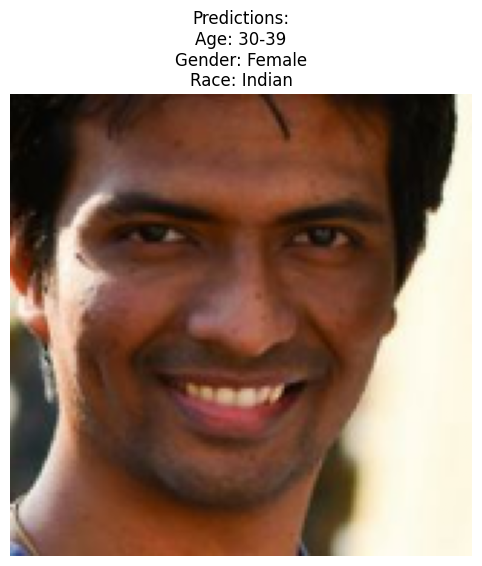

Predicted - Age: 30-39, Gender: Female, Race: Indian
Correct - Age: False, Gender: False, Race: True

=== Sample 2 ===
True labels - Age: 10-19, Gender: Female, Race: Indian


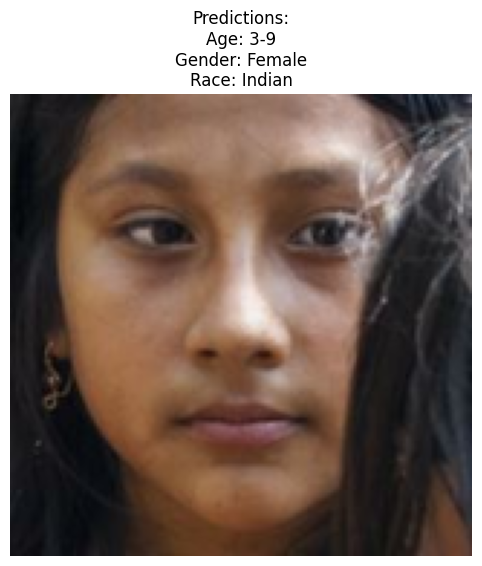

Predicted - Age: 3-9, Gender: Female, Race: Indian
Correct - Age: False, Gender: True, Race: True

=== Sample 3 ===
True labels - Age: 10-19, Gender: Female, Race: East Asian


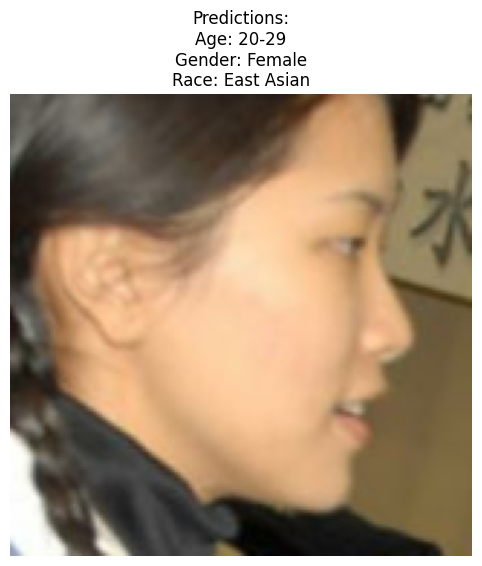

Predicted - Age: 20-29, Gender: Female, Race: East Asian
Correct - Age: False, Gender: True, Race: True

=== Sample 4 ===
True labels - Age: 20-29, Gender: Male, Race: White


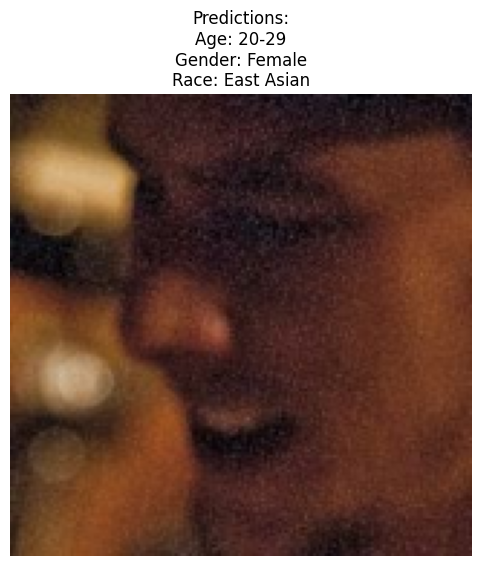

Predicted - Age: 20-29, Gender: Female, Race: East Asian
Correct - Age: True, Gender: False, Race: False

=== Sample 5 ===
True labels - Age: 30-39, Gender: Male, Race: Latino_Hispanic


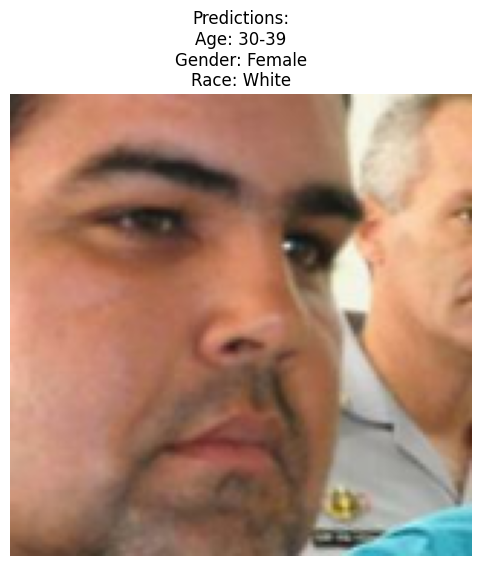

Predicted - Age: 30-39, Gender: Female, Race: White
Correct - Age: True, Gender: False, Race: False


In [20]:
test_predictions(model, train_processor, num_samples=5)

In [51]:
print(model.summary())

Model: "face_net_multi_task_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v1             │ (None, 512)            │    23,497,424 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense (Dense)            │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_head (Sequential)           │ (None, 9)              │        66,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_head (Sequential)        │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ race_head (Sequential)          │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,498,181 (93.45 MB)

 Trainable params: 333,585 (1.27 MB)

 Non-trainable params: 23,497,424 (89.64 MB)

 Optimizer params: 667,172 (2.55 MB)

None


In [ ]:
# !pip install lime shap tf-explain alibi opencv-python scikit-image slicer lazy_loader numba cloudpickle spacy transformers attrs dill

In [21]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# LIME
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# SHAP
import shap

# TF-Explain
import tf_explain
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients as TFIntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

# Alibi
# from alibi.explainers import IntegratedGradients as AlibiIG

print("✅ All packages installed successfully")


✅ All packages installed successfully


In [77]:
class TensorFlowModelExplainer:
    def __init__(self, model, data_processor, task='age_output'):
        self.model = model
        self.data_processor = data_processor
        self.task = task
        
        if task == 'age_output':
            self.label_encoder = data_processor.age_encoder
        elif task == 'gender_output':
            self.label_encoder = data_processor.gender_encoder
        elif task == 'race_output':
            self.label_encoder = data_processor.race_encoder
        
        print(f"Explainer ready for {task}. Classes: {list(self.label_encoder.classes_)}")
    
    def preprocess_image(self, image_path):
        return self.data_processor.load_and_preprocess_image(image_path, augment=False)
    
    def predict_proba(self, images):
        if not isinstance(images, tf.Tensor):
            if images.ndim == 3:  
                images = images[np.newaxis, ...]
            images = tf.convert_to_tensor(images, dtype=tf.float32)
            if tf.reduce_max(images) > 1.0:
                images = images / 255.0
            images = tf.image.per_image_standardization(images)
        
        predictions = self.model(images, training=False)
        probs = tf.nn.softmax(predictions[self.task])
        return probs.numpy()
    
    def predict_class(self, images):
        return np.argmax(self.predict_proba(images), axis=1)
    
    def get_single_prediction(self, image_path):
        image = self.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        predictions = self.model(image, training=False)
        probs = tf.nn.softmax(predictions[self.task])
        
        pred_class = tf.argmax(probs, axis=1)[0].numpy()
        confidence = probs[0, pred_class].numpy()
        label = self.label_encoder.inverse_transform([pred_class])[0]
        
        return {
            'predicted_class': pred_class,
            'predicted_label': label,
            'confidence': confidence,
            'all_probabilities': probs[0].numpy(),
            'class_names': list(self.label_encoder.classes_),
        }


In [78]:
class TensorFlowLIMEExplainer:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.explainer = lime_image.LimeImageExplainer()
        
    def explain_image(self, image_path, num_samples=1000):
        image_pil = Image.open(image_path).convert('RGB')
        image_np = np.array(image_pil.resize((160, 160)))
        
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print(f"Explaining: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
        
        def lime_predict_fn(images):
            processed = []
            for img in images:
                img = img.astype(np.float32) / 255.0
                img = tf.image.per_image_standardization(img)
                processed.append(img.numpy())
            return self.model_explainer.predict_proba(np.array(processed))
        
        explanation = self.explainer.explain_instance(
            image_np, lime_predict_fn,
            top_labels=len(pred_info['class_names']),
            num_samples=num_samples,
            segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
        )
        return explanation, pred_info, image_np


In [79]:
class TensorFlowIntegratedGradients:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.ig_explainer = TFIntegratedGradients()
    
    def explain_image(self, image_path, steps=50):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        predicted_class = pred_info['predicted_class']
        image_np = image.numpy()

        # pred_tensor = self.model(image, training=False)
        # if isinstance(pred_tensor, dict):
        #     pred_tensor = pred_tensor[self.model_explainer.task]
        def model_wrapper(x):
            preds = self.model(x, training=False)
            if isinstance(preds, dict):
                preds = preds[self.model_explainer.task]
            return preds

        attributions = self.ig_explainer.explain(
            validation_data=(image_np, None),
            model=model_wrapper,
            # model=self.model,
            class_index=predicted_class,
            n_steps=steps
        )
        return attributions, pred_info, image


In [80]:
class TensorFlowGradCAM:
    def __init__(self, model_explainer, layer_name=None):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        if layer_name is None:
            for layer in reversed(self.model.layers):
                if 'conv' in layer.name.lower() or 'inception' in layer.name.lower():
                    layer_name = layer.name
                    break
        self.layer_name = layer_name
        self.gradcam_explainer = GradCAM()

    
    
    def explain_image(self, image_path):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)

        pred_info = self.model_explainer.get_single_prediction(image_path)
        predicted_class = pred_info['predicted_class']


        def _create_functional_wrapper(self):
            """
            Create a functional model that wraps your subclassed model
            """
            # Define input shape (based on your model)
            input_shape = (160, 160, 3)
            inputs = tf.keras.Input(shape=input_shape)
            
            # Get embeddings from backbone
            embeddings = self.model.backbone(inputs)
            
            # Shared processing
            shared_features = self.model.shared_dense(embeddings)
            shared_features = self.model.shared_dropout(shared_features)
            
            # Get task-specific output
            if self.task == 'age_output':
                outputs = self.model.age_classifier(shared_features)
            elif self.task == 'gender_output':
                outputs = self.model.gender_classifier(shared_features)
            elif self.task == 'race_output':
                outputs = self.model.race_classifier(shared_features)
            else:
                raise ValueError(f"Unknown task: {self.task}")
            
            # Create functional model
            functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)
            return functional_model

        gradcam_heatmap = self.gradcam_explainer.explain(
            validation_data=(image.numpy(), None),
            model=_create_functional_wrapper,
            class_index=predicted_class,
            layer_name=self.layer_name
        )

        return gradcam_heatmap, pred_info, image

In [81]:
class TensorFlowOcclusion:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.occlusion_explainer = OcclusionSensitivity()
    
    def explain_image(self, image_path, patch_size=15):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        predicted_class = pred_info['predicted_class']

        def model_wrapper(x):
            """
            Wrapper to ensure model returns numerical probabilities
            """
            preds = self.model(x, training=False)
            
            # Handle dictionary output (multi-task models)
            if isinstance(preds, dict):
                preds = preds[self.task]
            
            # Ensure we have numerical probabilities
            # Apply softmax if raw logits, otherwise assume already probabilities
            if tf.reduce_max(preds) > 1.0 or tf.reduce_min(preds) < 0.0:
                preds = tf.nn.softmax(preds, axis=-1)
            
            return preds
        
        
        occlusion_map = self.occlusion_explainer.explain(
            validation_data=(image.numpy(), None),
            model=model_wrapper,
            # model=self.model,
            class_index=predicted_class,
            patch_size=patch_size
        )
        return occlusion_map, pred_info, image


In [82]:
class TensorFlowSHAP:
    def __init__(self, model_explainer, background_images):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.explainer = shap.DeepExplainer(self.model, background_images)
    
    def explain_image(self, image_path):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        shap_values = self.explainer.shap_values(image.numpy())
        return shap_values, pred_info, image


In [83]:
def explain_tensorflow_prediction_comprehensive(model, data_processor, image_path, task='age'):
    print(f"🔍 Explaining {task} prediction for {image_path}")
    model_explainer = TensorFlowModelExplainer(model, data_processor, task)
    pred_info = model_explainer.get_single_prediction(image_path)
    print(f"Prediction: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
    
    lime_explainer = TensorFlowLIMEExplainer(model_explainer)
    lime_exp, _, img_np = lime_explainer.explain_image(image_path)
    
    ig_explainer = TensorFlowIntegratedGradients(model_explainer)
    ig_attrs, _, _ = ig_explainer.explain_image(image_path)
    
    # gradcam_explainer = TensorFlowGradCAM(model_explainer)
    # gradcam_heatmap, _, _ = gradcam_explainer.explain_image(image_path)
    
    occ_explainer = TensorFlowOcclusion(model_explainer)
    # occ_map, _, _ = occ_explainer.explain_image(image_path)
    
    return {
        'lime_explanation': lime_exp,
        'ig_attributions': ig_attrs,
        # 'gradcam_heatmap': gradcam_heatmap,
        # 'occlusion_map': occ_map,
        'prediction_info': pred_info
    }


In [84]:
IMAGE_PATH = "C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg"


image = tf.expand_dims(val_processor.load_and_preprocess_image(IMAGE_PATH), 0)
predictions = model(image, training=False)
print(type(predictions))
print(predictions)


<class 'dict'>
{'age_output': <tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[7.9918364e-03, 3.5885605e-01, 9.3833923e-02, 5.0852066e-01,
        2.3686694e-02, 5.5633122e-03, 1.1236275e-03, 4.0864944e-04,
        1.5150373e-05]], dtype=float32)>, 'gender_output': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48473352]], dtype=float32)>, 'race_output': <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.01011632, 0.2663594 , 0.18763013, 0.1528089 , 0.01543404,
        0.3431475 , 0.02450375]], dtype=float32)>}


In [85]:
# IMAGE_PATH = os.path.join(VAL_IMG_DIR, "1.jpg")
IMAGE_PATH = "C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg"
explanations = explain_tensorflow_prediction_comprehensive(model, val_processor, IMAGE_PATH, task="race_output")


🔍 Explaining race_output prediction for C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg
Explainer ready for race_output. Classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Prediction: Southeast Asian (0.173)
Explaining: Southeast Asian (0.173)


100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]


In [86]:
class TensorFlowLIMEExplainer1:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.explainer = lime_image.LimeImageExplainer()
        
    def explain_and_visualize(self, image_path, num_samples=1000):
        image_pil = Image.open(image_path).convert('RGB')
        image_np = np.array(image_pil.resize((160, 160)))
        
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print(f"Explaining: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
        
        def lime_predict_fn(images):
            processed = []
            for img in images:
                img = img.astype(np.float32) / 255.0
                img = tf.image.per_image_standardization(img)
                processed.append(img.numpy())
            return self.model_explainer.predict_proba(np.array(processed))
        
        explanation = self.explainer.explain_instance(
            image_np, lime_predict_fn,
            top_labels=len(pred_info['class_names']),
            num_samples=num_samples,
            segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
        )
        
        # Visualization
        temp, mask = explanation.get_image_and_mask(
            pred_info['predicted_class'], positive_only=False, num_features=10, hide_rest=False)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[1].imshow(temp)
        axes[1].set_title("LIME Explanation")
        axes[2].imshow(mask, cmap="RdYlBu_r")
        axes[2].set_title("Important Regions")
        for ax in axes: ax.axis("off")
        plt.show()
        
        return explanation, pred_info, image_np


In [87]:
class TensorFlowSHAP1:
    def __init__(self, model_explainer, background_images):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.explainer = shap.DeepExplainer(self.model, background_images)
    
    def explain_and_visualize(self, image_path):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        shap_values = self.explainer.shap_values(image.numpy())
        
        shap_sum = np.sum(np.abs(shap_values[0][0]), axis=-1)
        plt.imshow(shap_sum, cmap="Reds")
        plt.title(f"SHAP - {pred_info['predicted_label']}")
        plt.axis("off")
        plt.show()
        
        return shap_values, pred_info, image


In [88]:
def explain_prediction_comprehensive(model, data_processor, image_path, task='age'):
    print(f"🔍 Explaining {task} prediction for {image_path}")
    model_explainer = TensorFlowModelExplainer(model, data_processor, task)
    pred_info = model_explainer.get_single_prediction(image_path)
    print(f"Prediction: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
    
    TensorFlowLIMEExplainer1(model_explainer).explain_and_visualize(image_path)
    # TensorFlowIntegratedGradients(model_explainer).explain_and_visualize(image_path)
    # TensorFlowGradCAM(model_explainer).explain_and_visualize(image_path)
    # TensorFlowOcclusion(model_explainer).explain_and_visualize(image_path)
    # For SHAP, you need to pass background images manually.
    
    return pred_info


🔍 Explaining race_output prediction for C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg
Explainer ready for race_output. Classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Prediction: Southeast Asian (0.173)
Explaining: Southeast Asian (0.173)


100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]


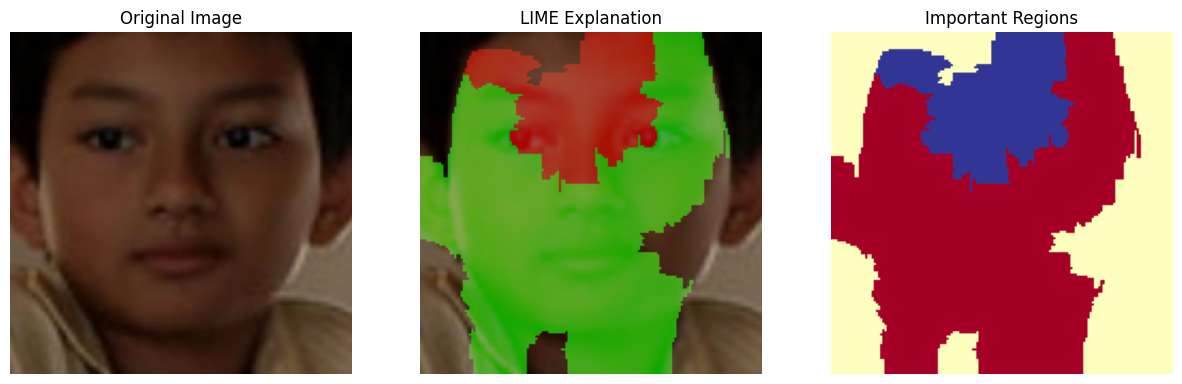

In [89]:
# IMAGE_PATH = os.path.join(VAL_IMG_DIR, "1.jpg")
IMAGE_PATH = "C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg"
explanations = explain_prediction_comprehensive(model, val_processor, IMAGE_PATH, task="race_output")
